In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output

## Load dataset
We first load and preprocess load demand data from [Albania](https://data.dtu.dk/articles/dataset/Albanian_national_electricity_consumption_and_weather_conditions_for_2016-2019/22786922) from a Parquet file format. 


In [2]:
data = pd.read_parquet("../data/albania_res.parquet")
data.index = pd.to_datetime(data.index, utc="UTC")

## Create data pipeline

Then we  sett up data transformation and scaling for time series forecasting. The goal is to prepare the dataset for modeling by defining the necessary parameters for the transformation and scaling processes.

For this purpose we use ``DatasetObjective`` A utility from mlpforecast for managing dataset objectives, crucial for time series forecasting.

In [3]:
from mlpforecast.data.transform import DatasetObjective

To achive this we define set of variables as follow

- target_series: The target variable to be predicted; in this case, "NetLoad".
- unknown_features: Any fnumerical eatures not observed in the future etc demand price.
- calendar_variables: Features derived from the calendar, such as hour and session.
- known_calendar_features: Precomputed features that represent the calendar variables.
- known_continuous_features: Continuous features used in the modeling process, including lagged variables and temperature.
- input_window_size: The size of the input window for the model (96 time steps).
- forecast_horizon: The forecasting horizon (48 time steps).

In [4]:
common_params = {
    "target_series": ["NetLoad"],
    "unknown_features": [],
    "calendar_variables": ["HOUR", "Session"],
    "known_calendar_features": ["HOUR-cosin", "Session-cosin"],
    "known_continuous_features": ["NetLoad_lag_48", "NetLoad_lag_336", "Temperature"],
    "input_window_size": 96,
    "forecast_horizon": 48,
}

Then we specify how we want to transform the data adding more features such as lagging or rolling window and scaling function using sklaern processing scaler

In [43]:
from sklearn.preprocessing import (
    MinMaxScaler,
    RobustScaler,
    PowerTransformer,
)

data_params = {
    "input_scaler": PowerTransformer('yeo-johnson'),
    "target_scaler": PowerTransformer('box-cox'),
    "lags": [1, 7],
    "windows": [],
    "window_funcs": ["mean"],
    "period": "30min",
    "date_column": "timestamp",
}

We update the parameters and define the  ``DatasetObjective``. This line ```data_params.update(common_params)`` merges common_params into data_params, ensuring all relevant settings are included for the dataset transformation.

In [44]:
data_params.update(common_params)
ds = DatasetObjective(**data_params)
clear_output()


Since the dataset objective is an instance of sklearn object it implement two main function ```fit``` and ```transform```. The ```fit```  fit the DatasetObjective object (ds) to the provided data, ensuring that the transformations and scaling parameters are applied correctly to the dataset.

In [45]:
ds.fit(data.reset_index())
clear_output()

This fitted data processing pipeline associated with the DatasetObjective instance contains all the transformation steps that will be applied to the dataset.

In [46]:
ds.data_pipeline

Pipeline(steps=[('feature_extraction',
                 Pipeline(steps=[('lags_step',
                                  FunctionTransformer(func=<function augment_lags at 0x1544af240>,
                                                      kw_args={'date_column': 'timestamp',
                                                               'lags': [48,
                                                                        336],
                                                               'value_column': ['NetLoad']})),
                                 ('dropnan_step',
                                  FunctionTransformer(func=<function DatasetObjective._build_feature_pipeline.<locals>.<lambda> at 0x32ceeec00>))])),
                ('scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('feat_scaler',
                                                  Pipeline(steps=[('scaler',
                                                                   PowerTransformer())]),
                                                  ['NetLoad_lag_48',
                                                   'NetLoad_lag_336',
                                                   'Temperature']),
                                                 ('target_scaler',
                                                  Pipeline(steps=[('target_scaler',
                                                                   PowerTransformer(method='box-cox'))]),
                                                  ['NetLoad'])],
                                   verbose_feature_names_out=False))])

To apply the fitted transform to the data we call ```transform``` function. The transformed data will produce sequences of features and targets that can be directly consumed by a model, streamlining the forecasting process.

In [47]:
x, y = ds.transform(data.reset_index())

After fitting and transforming the dataset, you can proceed to analyze the transformed data, and train forecasting models using the prepared feature and target sequences.

## Setting Up Visualization

In [48]:
import arviz as az
import matplotlib
import matplotlib.pyplot as plt

az.style.use(["science", "arviz-doc", "tableau-colorblind10"])
nice_fonts = {
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.05,
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "legend.frameon": False,
}
matplotlib.rcParams.update(nice_fonts)
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats(
    "svg", "pdf", "retina"
)  # For export

 Visualize the transformed data

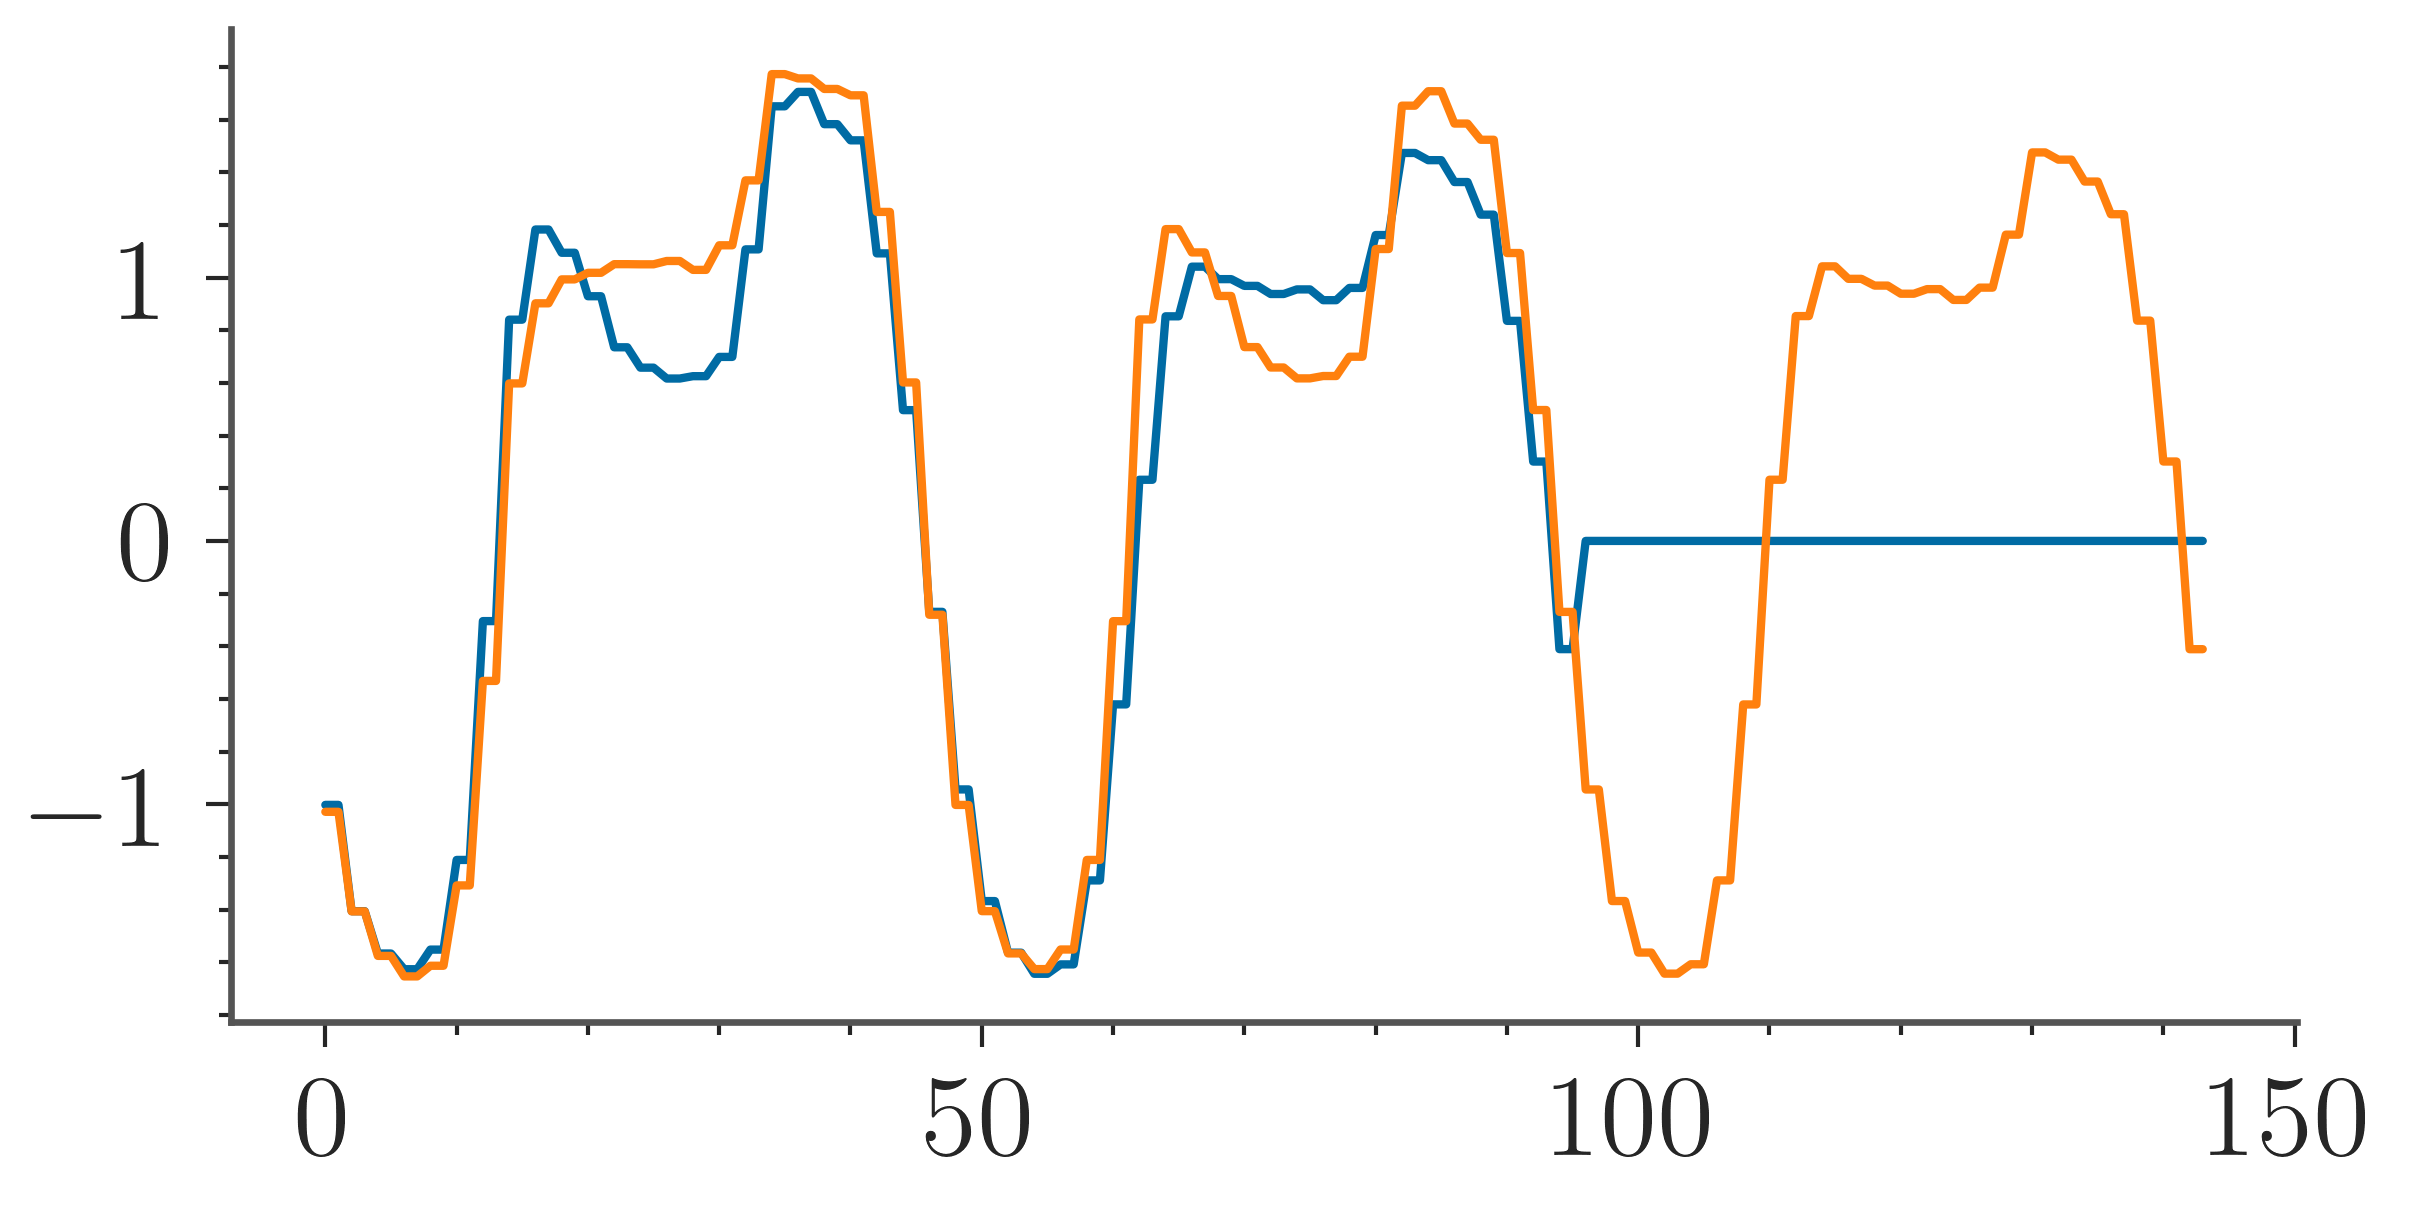

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
ax.plot(x[0, :, :2]);

## Building the Forecasting Model

To build the forecasting model, we first create an instance of ```MLPForecast```, a forecasting model from mlpforecast designed to handle time series forecasting tasks. One of the inputs to ```MLPForecast``` is the data pipeline created in the preceding cell. The  we define the following `model_hparams` as a dictionary.

- **data_pipeline**: The fitted data pipeline from the previous steps.
- **embedding_size**: Size of the embedding layer.
- **embedding_type**: Type of embedding to use (set to `None` here).
- **combination_type**: Method for combining features (set to `"addition-comb"`).
- **hidden_size**: Number of hidden units in the model (256).
- **num_layers**: Number of layers in the model (2).
- **expansion_factor**: Factor for expanding the dimensionality of the data (2).
- **residual**: Whether to use residual connections (set to `True`).
- **activation_function**: Activation function for the model (set to `"SiLU"`).
- **out_activation_function**: Activation function for output (set to `"Identity"`).
- **dropout_rate**: Rate of dropout for regularization (0.2).
- **alpha**: Parameter for the model (0.5).
- **max_epochs**: Maximum number of epochs for training (10).

In [51]:
from mlpforecast.forecaster.mlp import MLPForecast

model_hparams = {
    "data_pipeline": ds,
    "embedding_size": 16,
    "embedding_type": None,
    "combination_type": "addition-comb",
    "hidden_size": 256,
    "num_layers": 2,
    "expansion_factor": 2,
    "residual": True,
    "activation_function": "ReLU",
    "out_activation_function": "Identity",
    "dropout_rate": 0.2,
    "alpha": 0.5,
    "max_epochs": 20,
}
model_hparams.update(common_params)
model = MLPForecast(
    exp_name="test", model_type="MLPF", hparams=model_hparams, rich_progress_bar=False
)

## Training the Model

To train the model, use the following code:

```python
model.fit()
````

In [52]:
model.fit(data.reset_index()[:20000])
clear_output()

To make predictions, use the following code:


In [53]:
out = model.predict(data.reset_index()[20000 : 20000 + 48 * 7 * 2])
clear_output()

This command predicts the next 48*7*2 time steps based on the dataset. we can visualize the predictions as follows using ```mlpforecast.plot``` functionality





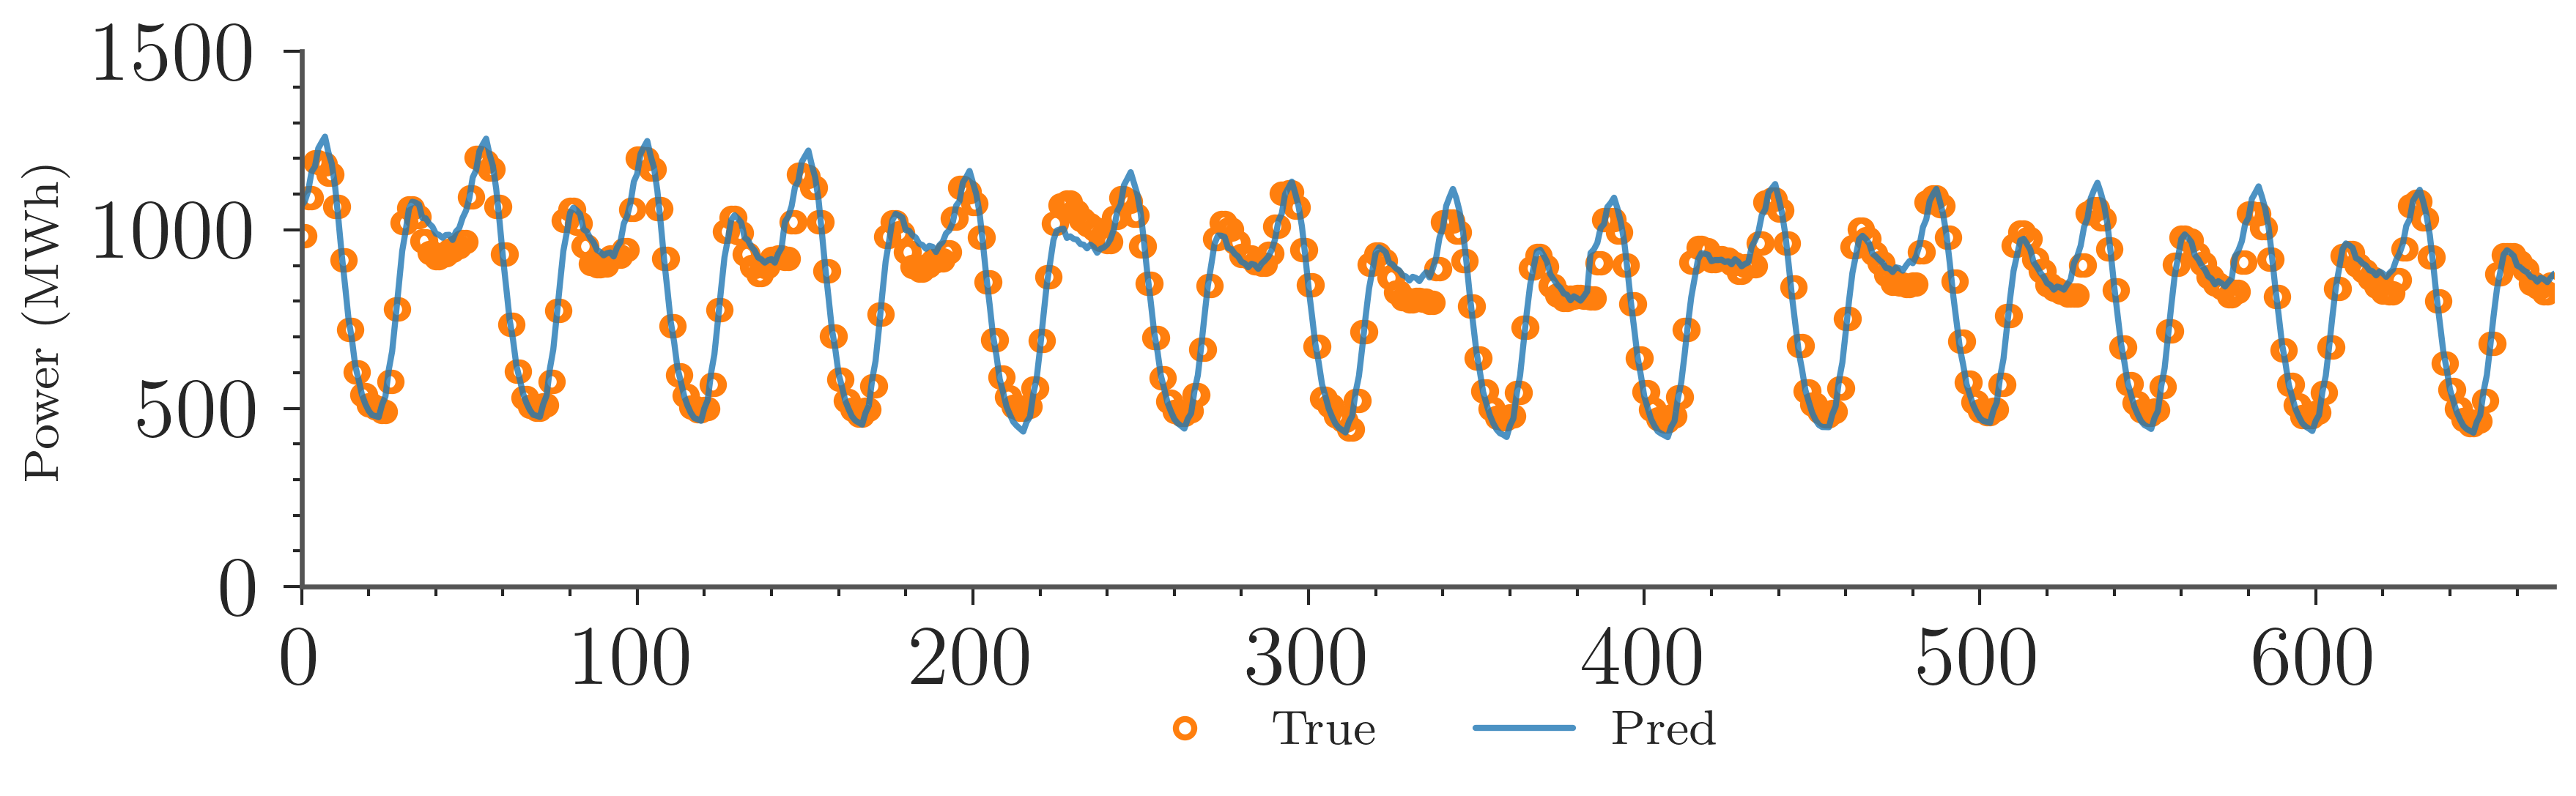

In [54]:
from mlpforecast.plot.visual_functions import plot_prediction

fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax = plot_prediction(ax, true=out["NetLoad"].values, mu=out["NetLoad_forecast"].values)
ax.set_ylim(0, 1500)
ax.set_ylabel("Power (MWh)")
fig.tight_layout(pad=1.08, h_pad=0.5, w_pad=0.5)

This code create a plot showing the true values versus the predicted values for "NetLoad", with the y-axis labeled in MWh and proper layout settings applied.



In [55]:
met = ["RMSE", "MAE", "MAPE(%)", "CORR", "R2-error", "NBIAS", "SMAPE(%)"]
model.metrics.groupby("target")[met].mean().round(2)

,RMSE,MAE,MAPE(%),CORR,R2-error,NBIAS,SMAPE(%)
target,,,,,,,
NetLoad,43.79,35.58,4.49,0.98,0.96,-0.14,4.46


## Backtesting the Model
The library allows you to perform backtesting to evaluate the model across multiple time splits. Use the following code to set up backtesting:

In [56]:
from mlpforecast.evaluation.backtester import BacktestingForecast

backtest = BacktestingForecast(
    forecast_len=4,
    incremental_len=2,
    min_train_len=12,
    n_splits=10,
    window_type="expanding",
)

Next, you need to set up the model using partial:



In [ ]:
from functools import partial

model = partial(MLPForecast, hparams=model_hparams, exp_name="bactesting")

To perform the backtesting, run the following code:

In [ ]:
pred_df, metric_df = backtest.fit(data.reset_index(), model_instance=model)
clear_output()

Finally, to evaluate the results, you can compute the mean of metrics across folds:


In [ ]:
metric_df.groupby(["target", "Folds"])[met].mean().round(2)

## Hyper-parameter tuning

In [ ]:
model = MLPForecast(hparams=model_hparams, exp_name="hyper")
model.auto_tune(data.reset_index()[:20000], data.reset_index()[:20000])

In [ ]:
model.hparams